<a href="https://colab.research.google.com/github/Sabbir-Hossain-A/credit_card_fraud_detection-/blob/main/credit_card_fraud_detection_(CNN_%2B_BiLSTM_Model%2C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# ==========================================================
# 🚀 CREDIT CARD FRAUD DETECTION (Advanced DL Version)
# ==========================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from sklearn.utils import class_weight

# -------------------------------
# 1️⃣ Load Dataset
# -------------------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard.csv")
print("✅ Dataset loaded:", df.shape)
print(df["Class"].value_counts())

✅ Dataset loaded: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [11]:
# -------------------------------
# 2️⃣ Handle Outliers
# -------------------------------
Q1, Q3 = df['Amount'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df['Amount'] = df['Amount'].clip(lower, upper)

In [12]:
# -------------------------------
# 3️⃣ Scale Data
# -------------------------------
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

In [13]:
# -------------------------------
# 4️⃣ Split Data
# -------------------------------
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (227845, 30) Test shape: (56962, 30)


In [14]:
# -------------------------------
# 5️⃣ Resample using SMOTEENN
# -------------------------------
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
print("Resampled:", np.bincount(y_train_res))

Resampled: [227061 227451]


**Why SMOTEENN?**

The dataset is highly imbalanced, meaning there are significantly more instances of non-fraudulent transactions (Class 0) than fraudulent transactions (Class 1).

In [15]:
# -------------------------------
# 6️⃣ Define Focal Loss
# -------------------------------
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        mod_factor = K.pow((1 - p_t), gamma)
        return K.mean(alpha_factor * mod_factor * bce)
    return focal_loss_fixed


In [16]:
# -------------------------------
# 7️⃣ Build CNN + BiLSTM Model
# -------------------------------
input_dim = X_train_res.shape[1]
X_train_seq = X_train_res.values.reshape((-1, input_dim, 1))
X_test_seq = X_test.values.reshape((-1, input_dim, 1))

def build_cnn_bilstm(input_shape):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=focal_loss(), metrics=[keras.metrics.AUC(name='auc')])
    return model

In [17]:
# -------------------------------
# 8️⃣ Train Model
# -------------------------------
EPOCHS, BATCH_SIZE = 20, 512
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train_res),
                                       y=y_train_res)
cw = dict(enumerate(cw))

cnn_bilstm = build_cnn_bilstm((input_dim, 1))
cnn_bilstm.fit(X_train_seq, y_train_res,
               epochs=EPOCHS, batch_size=BATCH_SIZE,
               validation_split=0.1, verbose=2,
               class_weight=cw)

Epoch 1/20
799/799 - 189s - 237ms/step - auc: 0.9866 - loss: 0.0133 - val_auc: 0.0000e+00 - val_loss: 0.0082
Epoch 2/20
799/799 - 182s - 228ms/step - auc: 0.9993 - loss: 0.0036 - val_auc: 0.0000e+00 - val_loss: 0.0024
Epoch 3/20
799/799 - 180s - 226ms/step - auc: 0.9998 - loss: 0.0017 - val_auc: 0.0000e+00 - val_loss: 5.1820e-04
Epoch 4/20
799/799 - 202s - 253ms/step - auc: 0.9999 - loss: 0.0011 - val_auc: 0.0000e+00 - val_loss: 3.2198e-04
Epoch 5/20
799/799 - 201s - 252ms/step - auc: 0.9999 - loss: 8.6251e-04 - val_auc: 0.0000e+00 - val_loss: 0.0023
Epoch 6/20
799/799 - 185s - 231ms/step - auc: 1.0000 - loss: 6.9893e-04 - val_auc: 0.0000e+00 - val_loss: 2.9026e-04
Epoch 7/20
799/799 - 178s - 223ms/step - auc: 1.0000 - loss: 4.9414e-04 - val_auc: 0.0000e+00 - val_loss: 9.0911e-04
Epoch 8/20
799/799 - 182s - 227ms/step - auc: 1.0000 - loss: 4.0751e-04 - val_auc: 0.0000e+00 - val_loss: 1.8025e-04
Epoch 9/20
799/799 - 199s - 249ms/step - auc: 1.0000 - loss: 3.4056e-04 - val_auc: 0.0000e+0

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step

=== CNN+BiLSTM Report ===
              precision    recall  f1-score   support

           0     0.9998    0.9991    0.9994     56864
           1     0.6170    0.8878    0.7280        98

    accuracy                         0.9989     56962
   macro avg     0.8084    0.9434    0.8637     56962
weighted avg     0.9991    0.9989    0.9990     56962



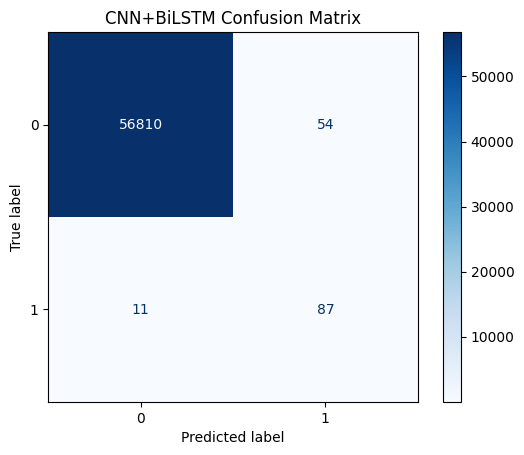

AUC: 0.9713866166894446


In [18]:
# -------------------------------
# 9️⃣ Evaluate CNN+BiLSTM
# -------------------------------
cnn_probs = cnn_bilstm.predict(X_test_seq).ravel()
cnn_preds = (cnn_probs >= 0.5).astype(int)
print("\n=== CNN+BiLSTM Report ===")
print(classification_report(y_test, cnn_preds, digits=4))

cm = confusion_matrix(y_test, cnn_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("CNN+BiLSTM Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, cnn_probs)
print("AUC:", roc_auc)

In [19]:
# -------------------------------
# 🔟 Build MLP_Focal for Ensemble
# -------------------------------
def build_mlp(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=focal_loss(), metrics=[keras.metrics.AUC(name='auc')])
    return model

mlp_focal = build_mlp(input_dim)
mlp_focal.fit(X_train_res, y_train_res,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              validation_split=0.1, verbose=2,
              class_weight=cw)

mlp_probs = mlp_focal.predict(X_test).ravel()
mlp_preds = (mlp_probs >= 0.5).astype(int)


Epoch 1/20
799/799 - 9s - 11ms/step - auc: 0.9970 - loss: 0.0077 - val_auc: 0.0000e+00 - val_loss: 0.0016
Epoch 2/20
799/799 - 4s - 5ms/step - auc: 0.9998 - loss: 0.0020 - val_auc: 0.0000e+00 - val_loss: 2.8562e-04
Epoch 3/20
799/799 - 6s - 8ms/step - auc: 0.9999 - loss: 0.0010 - val_auc: 0.0000e+00 - val_loss: 1.4211e-04
Epoch 4/20
799/799 - 4s - 5ms/step - auc: 0.9999 - loss: 7.4588e-04 - val_auc: 0.0000e+00 - val_loss: 9.7528e-05
Epoch 5/20
799/799 - 4s - 6ms/step - auc: 0.9999 - loss: 6.0164e-04 - val_auc: 0.0000e+00 - val_loss: 1.6670e-04
Epoch 6/20
799/799 - 6s - 7ms/step - auc: 1.0000 - loss: 4.7109e-04 - val_auc: 0.0000e+00 - val_loss: 7.8192e-05
Epoch 7/20
799/799 - 4s - 5ms/step - auc: 1.0000 - loss: 4.0914e-04 - val_auc: 0.0000e+00 - val_loss: 6.6296e-05
Epoch 8/20
799/799 - 5s - 7ms/step - auc: 1.0000 - loss: 3.7547e-04 - val_auc: 0.0000e+00 - val_loss: 3.9608e-05
Epoch 9/20
799/799 - 5s - 7ms/step - auc: 1.0000 - loss: 3.3125e-04 - val_auc: 0.0000e+00 - val_loss: 2.5543e-0


=== ENSEMBLE MODEL REPORT ===
              precision    recall  f1-score   support

           0     0.9998    0.9995    0.9996     56864
           1     0.7391    0.8673    0.7981        98

    accuracy                         0.9992     56962
   macro avg     0.8695    0.9334    0.8989     56962
weighted avg     0.9993    0.9992    0.9993     56962

Ensemble AUC: 0.9731647583062489


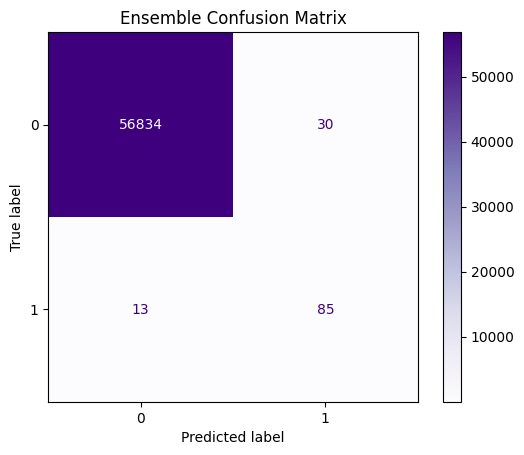

In [20]:
# -------------------------------
# 11️⃣ Ensemble (Average Voting)
# -------------------------------
ensemble_probs = (mlp_probs + cnn_probs) / 2
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

print("\n=== ENSEMBLE MODEL REPORT ===")
print(classification_report(y_test, ensemble_preds, digits=4))
print("Ensemble AUC:", roc_auc_score(y_test, ensemble_probs))

cm = confusion_matrix(y_test, ensemble_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Purples')
plt.title("Ensemble Confusion Matrix")
plt.show()


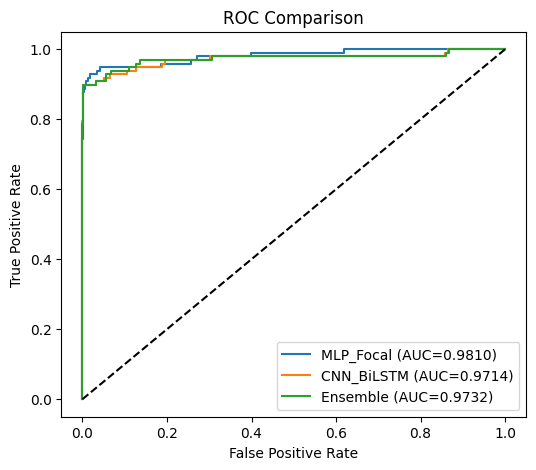

In [21]:
# -------------------------------
# 12️⃣ ROC Curves Comparison
# -------------------------------
plt.figure(figsize=(6,5))
for name, probs in {
    'MLP_Focal': mlp_probs,
    'CNN_BiLSTM': cnn_probs,
    'Ensemble': ensemble_probs
}.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, probs):.4f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.title("ROC Comparison")
plt.show()